In [2]:
import sys
import os
import argparse
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import csv
import traceback
import portion as P
from tqdm import tqdm
from pprint import pprint
from pytictoc import TicToc
from statistics import median
from statistics import mean
from statistics import mode
from statistics import stdev
from tabulate import tabulate
from prettytable import PrettyTable

# ******************************* User Settings *******************************
database = "/home/wmnlab/D/database/"
date = "2022-11-29"
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    "sm05",
    "sm06",
    "sm07",
    "sm08",
    # "qc00",
    # "qc01",
    # "qc02",
    # "qc03",
])
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "tsync": (1, None),
    # "_Bandlock_Udp": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp": (4, ["#03", "#04", "#05", "#06"]),
    # "_Bandlock_Udp": (4, []),
    # "_Bandlock_Udp": (6, []),
    # "_Bandlock_Udp_B1_B3":  (1, ["#01"]),
    "_Bandlock_Udp_B1_B3":  (4, []),
    "_Bandlock_Udp_B3_B28": (4, []),
    "_Bandlock_Udp_B28_B1": (4, []),
}

class Payload:
    LENGTH = 250              # (Bytes)
    TAG = "000425d401df5e76"  # 2 71828 3 1415926 (hex)            : 8-bytes
    OFS_TIME = (16, 24)       # epoch time of 'yyyy/mm/dd hh:mm:ss': 4-bytes
    OFS_USEC = (24, 32)       # microsecond (usec)                 : 4-bytes
    OFS_SEQN = (32, 40)       # sequence number (start from 1)     : 4-bytes
class ServerIP:
    PUBLIC = "140.112.20.183"  # 2F    
    PRIVATE = "192.168.1.251"  # 2F
    # PRIVATE = "192.168.1.248"  # 2F previous
    # PUBLIC = "140.112.17.209"  # 3F
    # PRIVATE = "192.168.1.108"  # 3F

DATA_RATE = 1000e3  # bits-per-second
PKT_RATE = DATA_RATE / Payload.LENGTH / 8  # packets-per-second
print("packet_rate (pps):", PKT_RATE, "\n")
# *****************************************************************************

def bpy_color_palette(n=50, cutoff_tails=0.1):
    """
    Generate a color palette with specific number.
    Ref. https://www.rdocumentation.org/packages/gstat/versions/0.9-22/topics/bpy.colors

    Args:
        n (int): number of colors
        cutoff_tails (float): tail fraction to be cut off. This palette runs from black to white if cutoff.tails is 0; by cutting off the tails, it runs from blue to yellow, which looks nicer.
    Returns:
        color_list (list): list of hex color code.
    """
    item_list = np.linspace(start=0.5 * cutoff_tails, stop=1 - 0.5 * cutoff_tails, num=n)
    color_list = []
    for i in item_list:
        ### R
        if(i < 0.25):
            r = 0
        elif(i < 0.57):
            r =  i / .32 - .78125
        else:
            r = 1
        ### G
        if(i < 0.42):
            g = 0
        elif(i < 0.92):
            g =  2 * i - .84
        else:
            g = 1
        ### B
        if(i < 0.25):
            b = 4 * i
        elif(i < 0.42):
            b =  1
        elif(i < 0.92):
            b =  -2 * i + 1.84
        else:
            b = i / .08 - 11.5
        ### append color
        color_list.append(mcolors.to_hex([ r, g, b ]))
    cmap = mcolors.ListedColormap(color_list, name='my_colormap')
    return cmap

def makedir(dirpath, mode=0):  # mode=1: show message; mode=0: hide message
    if os.path.isdir(dirpath):
        if mode:
            print("mkdir: cannot create directory '{}': directory has already existed.".format(dirpath))
        return
    ### recursively make directory
    _temp = []
    while not os.path.isdir(dirpath):
        _temp.append(dirpath)
        dirpath = os.path.dirname(dirpath)
    while _temp:
        dirpath = _temp.pop()
        print("mkdir", dirpath)
        os.mkdir(dirpath)

packet_rate (pps): 500.0 



### line chart of window size

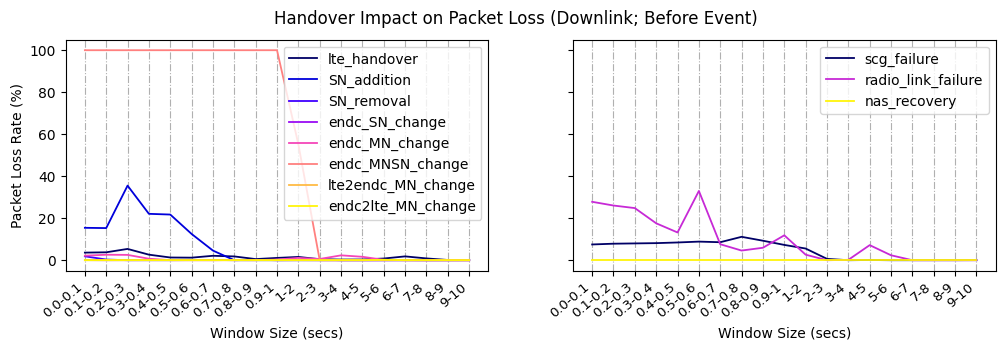

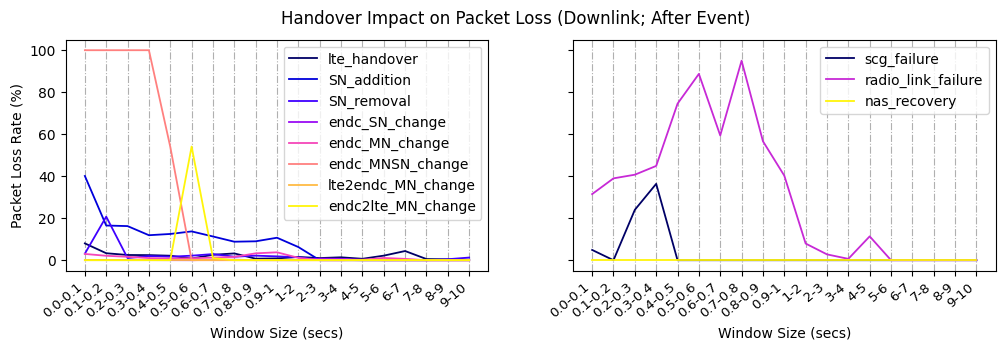

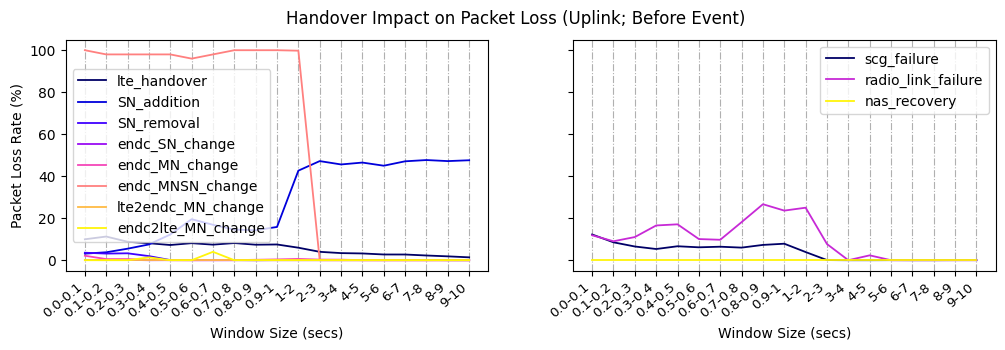

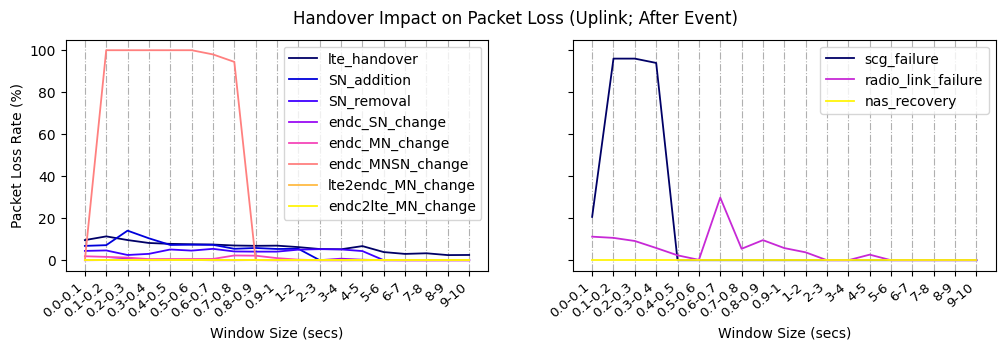

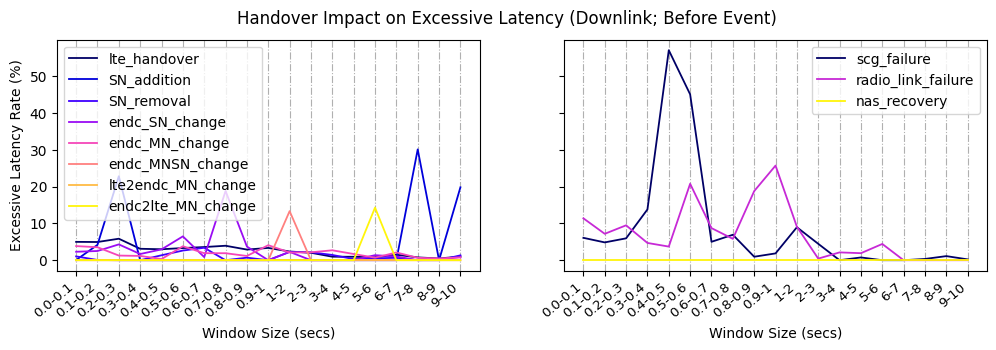

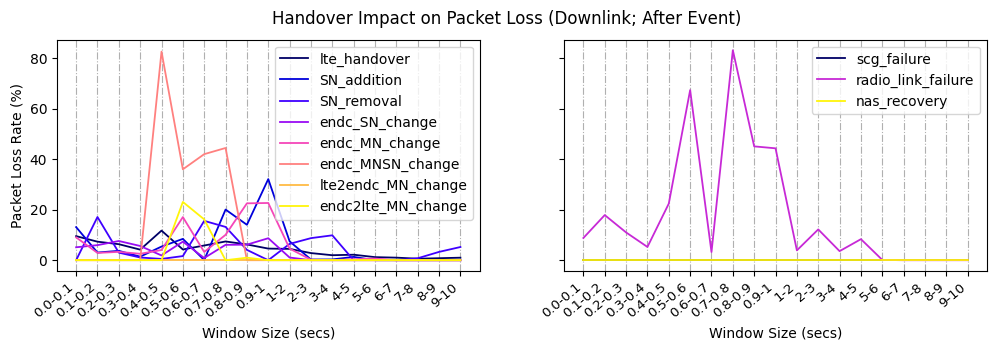

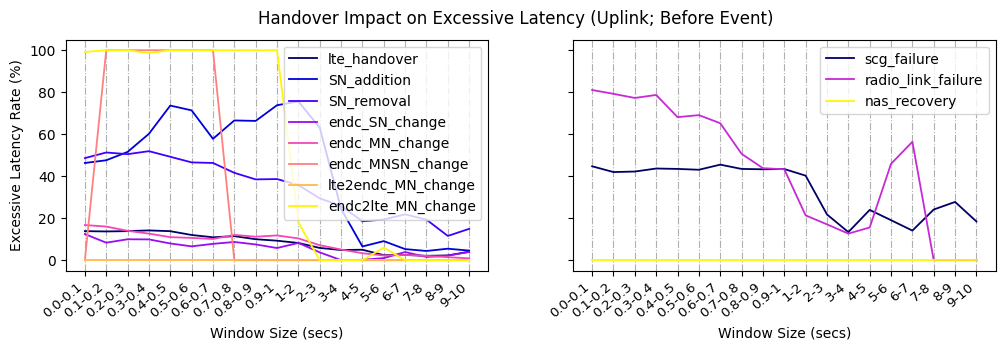

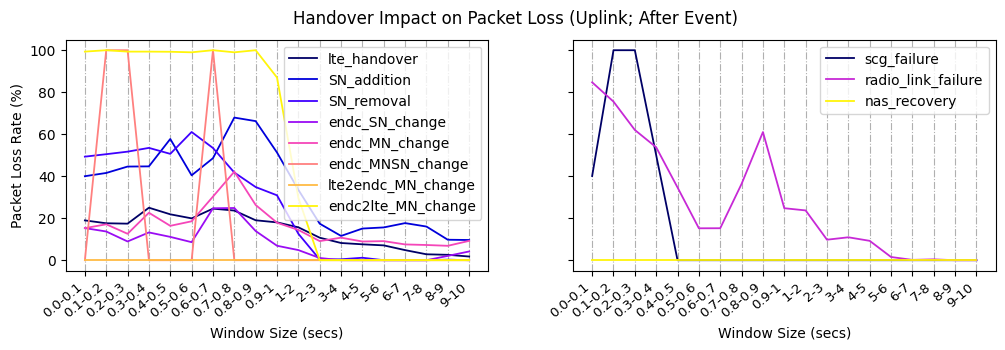

In [53]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    "_Bandlock_Udp_B1_B3": (4, ["#01", "#02", "#03", "#04"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B1_B3": (1, ["#04"]),
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# devices = ["sm05",]
# devices = ["sm06",]
# devices = ["sm07",]
# devices = ["sm08",]
# setnames = ["all", "b1", "b3", "b1b3"]
# setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
# _setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))

### TODO: Downlink Loss
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 1
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Downlink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_before.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 2
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Downlink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_after.png"), bbox_inches='tight')
plt.show()

### TODO: Uplink Loss
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 3
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Uplink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_before.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 4
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Uplink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_after.png"), bbox_inches='tight')
plt.show()

### TODO: Downlink Excessive Latency
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_excl_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 1
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Excessive Latency (Downlink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_before_excl.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 2
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Downlink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_after_excl.png"), bbox_inches='tight')
plt.show()

### TODO: Uplink
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "uplk_excl_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 3
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Excessive Latency (Uplink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_before_excl.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 4
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Uplink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_after_excl.png"), bbox_inches='tight')
plt.show()

mkdir /home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07/images/1-1(b3b28)


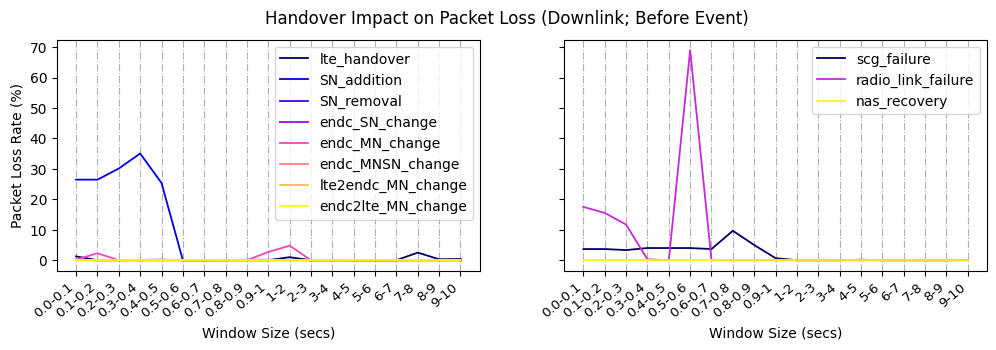

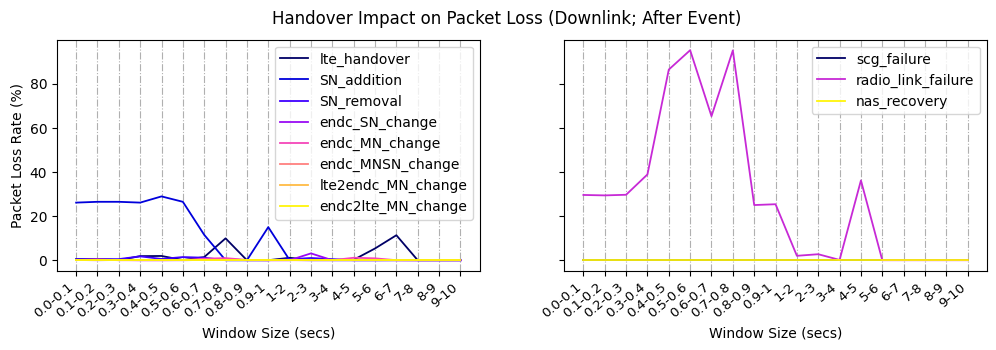

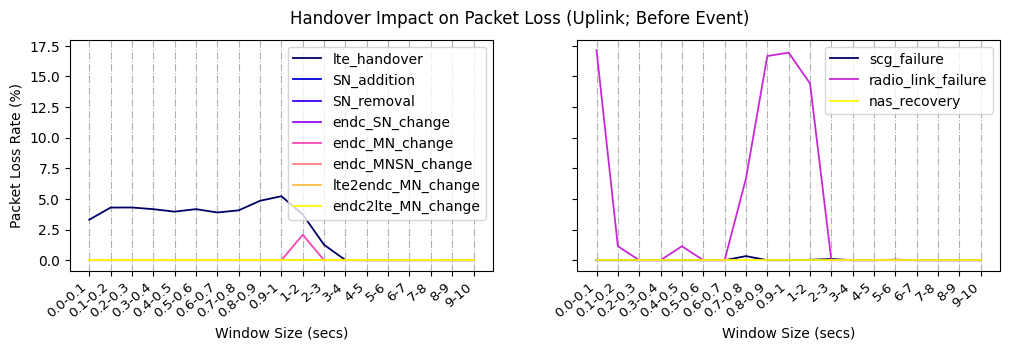

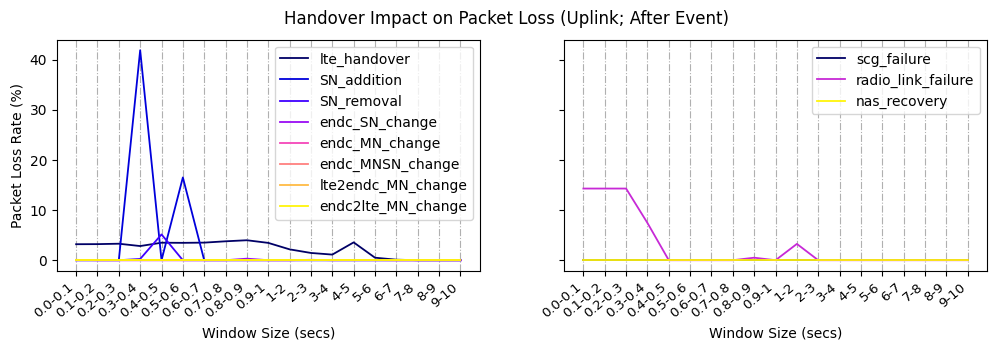

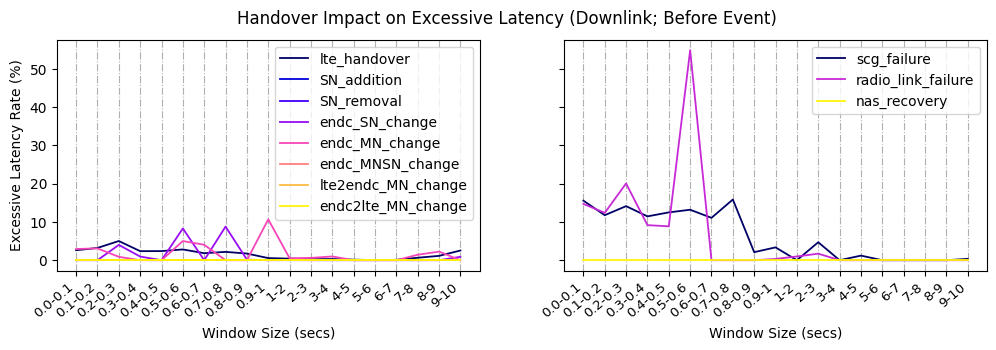

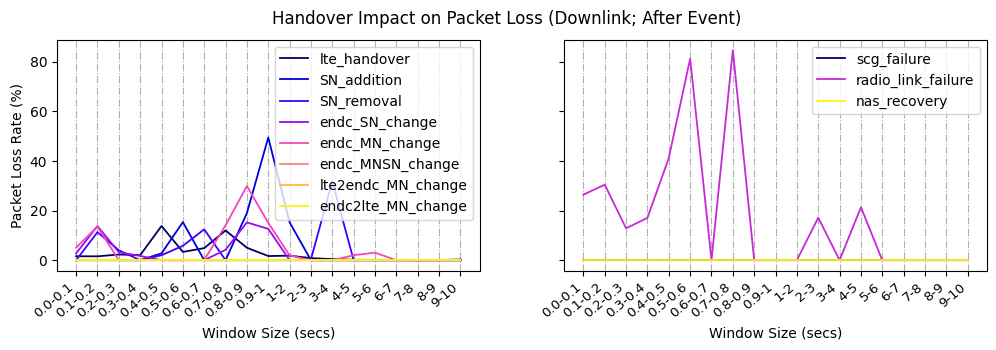

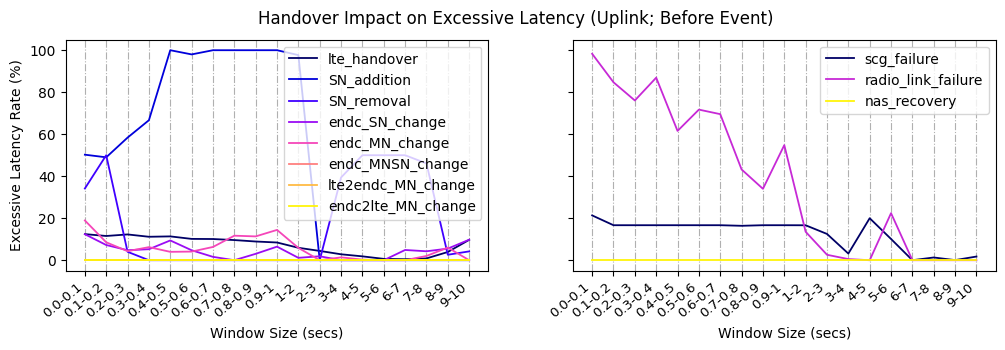

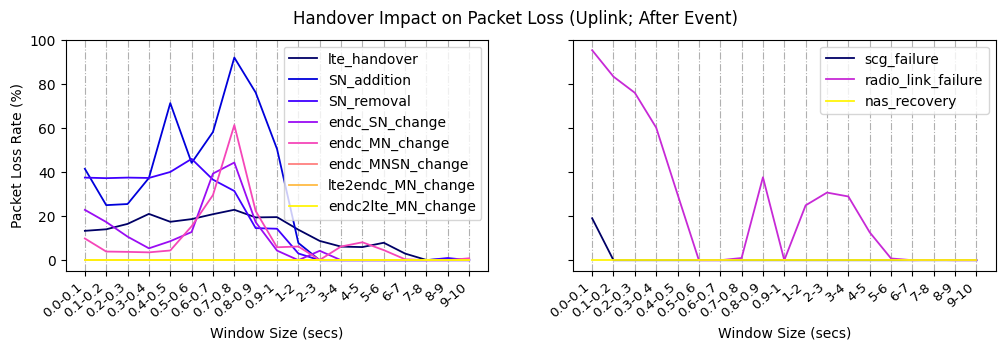

In [54]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B1_B3": (4, ["#01", "#02", "#03", "#04"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B1_B3": (1, ["#04"]),
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# devices = ["sm05",]
# devices = ["sm06",]
# devices = ["sm07",]
# devices = ["sm08",]
# setnames = ["all", "b1", "b3", "b1b3"]
# setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
# _setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))

### TODO: Downlink Loss
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 1
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Downlink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_before.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 2
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Downlink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_after.png"), bbox_inches='tight')
plt.show()

### TODO: Uplink Loss
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "uplk_loss_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#packet_loss"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#total_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 3
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Uplink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_before.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 4
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Uplink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_after.png"), bbox_inches='tight')
plt.show()

### TODO: Downlink Excessive Latency
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_excl_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 1
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Excessive Latency (Downlink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_before_excl.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 2
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Downlink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_after_excl.png"), bbox_inches='tight')
plt.show()

### TODO: Uplink
before_event_loss = {}
after_event_loss = {}
before_event_pkt = {}
after_event_pkt = {}
before_event_rate = {}
after_event_rate = {}
for type0 in handover_types + handover_fail_types:
    before_event_loss[type0] = [0] * len(ws0)
    before_event_pkt[type0] = [0] * len(ws0)
    before_event_rate[type0] = [0] * len(ws0)
    after_event_loss[type0] = [0] * len(ws0)
    after_event_pkt[type0] = [0] * len(ws0)
    after_event_rate[type0] = [0] * len(ws0)

for expr, (times, traces) in exps.items():
    # for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for k, dev in enumerate(devices):
        # print("----------------------")
        # print('@'.join([stg, dev]))
        # print(dev)
        # print("----------------------")
        for trace in traces:
            # print(trace)
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-uni")
            df = pd.read_csv(os.path.join(source_dir, "uplk_excl_classify_uni_type0.csv"))
            """"""
            # for _ws0, _ws1 in zip(ws0, ws1):
            for type0 in handover_types + handover_fail_types:
                # secs = "{}-{}".format(_ws0, _ws1)
                # print(type0)
                prior_loss = df["before_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                prior_pkt = df["before_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                prior_pkt = [y if y >= x else x for x, y in zip(prior_loss, prior_pkt)]
                post_loss = df["after_{}".format(type0)][df["metrics"] == "#excs_latency"].to_numpy()[1:]
                post_pkt = df["after_{}".format(type0)][df["metrics"] == "#recv_packets"].to_numpy()[1:]
                post_pkt = [y if y >= x else x for x, y in zip(post_loss, post_pkt)]
                # print(prior_loss)
                # print(prior_pkt)
                # print(post_loss)
                # print(post_pkt)
                before_event_loss[type0] = [sum(x) for x in zip(before_event_loss[type0], prior_loss)]
                before_event_pkt[type0] = [sum(x) for x in zip(before_event_pkt[type0], prior_pkt)]
                after_event_loss[type0] = [sum(x) for x in zip(after_event_loss[type0], post_loss)]
                after_event_pkt[type0] = [sum(x) for x in zip(after_event_pkt[type0], post_pkt)]

for type0 in handover_types + handover_fail_types:
    before_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(before_event_loss[type0], before_event_pkt[type0])]
    after_event_rate[type0] = [x / (y + 1e-9) * 100 for x, y in zip(after_event_loss[type0], after_event_pkt[type0])]

# for type0 in handover_types + handover_fail_types:
#     print(type0)
#     print(before_event_loss[type0])
#     print(before_event_pkt[type0])
#     print(before_event_rate[type0])
#     print(after_event_loss[type0])
#     print(after_event_pkt[type0])
#     print(after_event_rate[type0])

ws0 = [i/10 for i in range(0, 10)] + list(range(1, 10)) 
ws1 = [i/10 for i in range(1, 10)] + list(range(1, 11))
secs = ["{}-{}".format(_ws0, _ws1) for _ws0, _ws1 in zip(ws0, ws1)]

### TODO: Plot 3
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Excessive Latency (Uplink; Before Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, before_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_before_excl.png"), bbox_inches='tight')
plt.show()

### TODO: Plot 4
labels = secs
x = np.arange(len(labels))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(12, 3))
fig.suptitle('Handover Impact on Packet Loss (Uplink; After Event)')

cmap = bpy_color_palette(len(handover_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_types):
    ax1.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xticks(x, labels)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax1.set_xlabel('Window Size (secs)')
ax1.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax1.grid(axis='x', linestyle='-.')
ax1.legend()

cmap = bpy_color_palette(len(handover_fail_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]

for i, type0 in enumerate(handover_fail_types):
    ax2.plot(x, after_event_rate[type0], color_list[i], linewidth=1.3, label=type0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "1-1(b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "uplk_after_excl.png"), bbox_inches='tight')
plt.show()

### bar chart of each types

all@sm05
[85, 103704, 0.082]
[1962, 9310, 21.074]
[5, 253095, 0.002]
[2052, 366109, 0.56]
b3@sm06
[289, 81192, 0.356]
[864, 2566, 33.671]
[97, 232897, 0.042]
[1250, 316655, 0.395]
b28@sm07
[818, 81676, 1.002]
[553, 2387, 23.167]
[14, 220159, 0.006]
[1385, 304222, 0.455]
b3b28@sm08
[553, 106510, 0.519]
[391, 4487, 8.714]
[3, 218558, 0.001]
[947, 329555, 0.287]


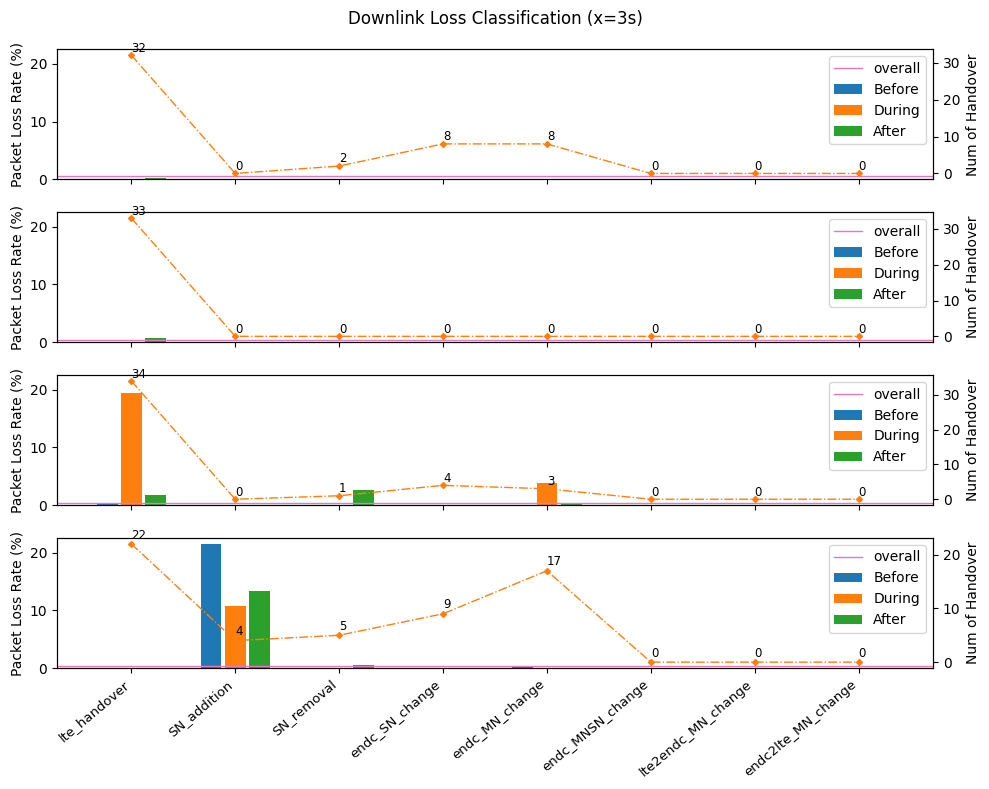

all@sm05
[85, 103704, 0.082]
[1962, 9310, 21.074]
[5, 253095, 0.002]
[2052, 366109, 0.56]
b3@sm06
[289, 81192, 0.356]
[864, 2566, 33.671]
[97, 232897, 0.042]
[1250, 316655, 0.395]
b28@sm07
[818, 81676, 1.002]
[553, 2387, 23.167]
[14, 220159, 0.006]
[1385, 304222, 0.455]
b3b28@sm08
[553, 106510, 0.519]
[391, 4487, 8.714]
[3, 218558, 0.001]
[947, 329555, 0.287]


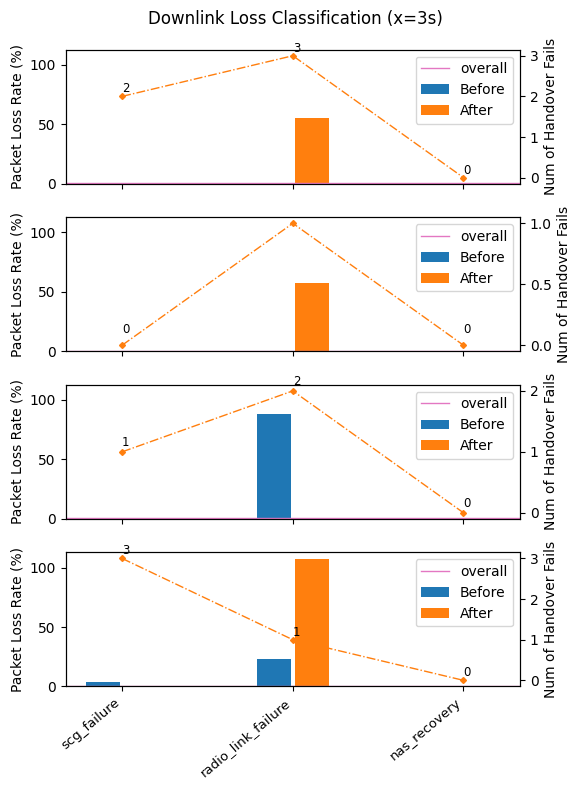

all@sm05
[85, 103704, 0.082]
[1962, 9310, 21.074]
[5, 253095, 0.002]
[2052, 366109, 0.56]
b3@sm06
[289, 81192, 0.356]
[864, 2566, 33.671]
[97, 232897, 0.042]
[1250, 316655, 0.395]
b28@sm07
[818, 81676, 1.002]
[553, 2387, 23.167]
[14, 220159, 0.006]
[1385, 304222, 0.455]
b3b28@sm08
[553, 106510, 0.519]
[391, 4487, 8.714]
[3, 218558, 0.001]
[947, 329555, 0.287]


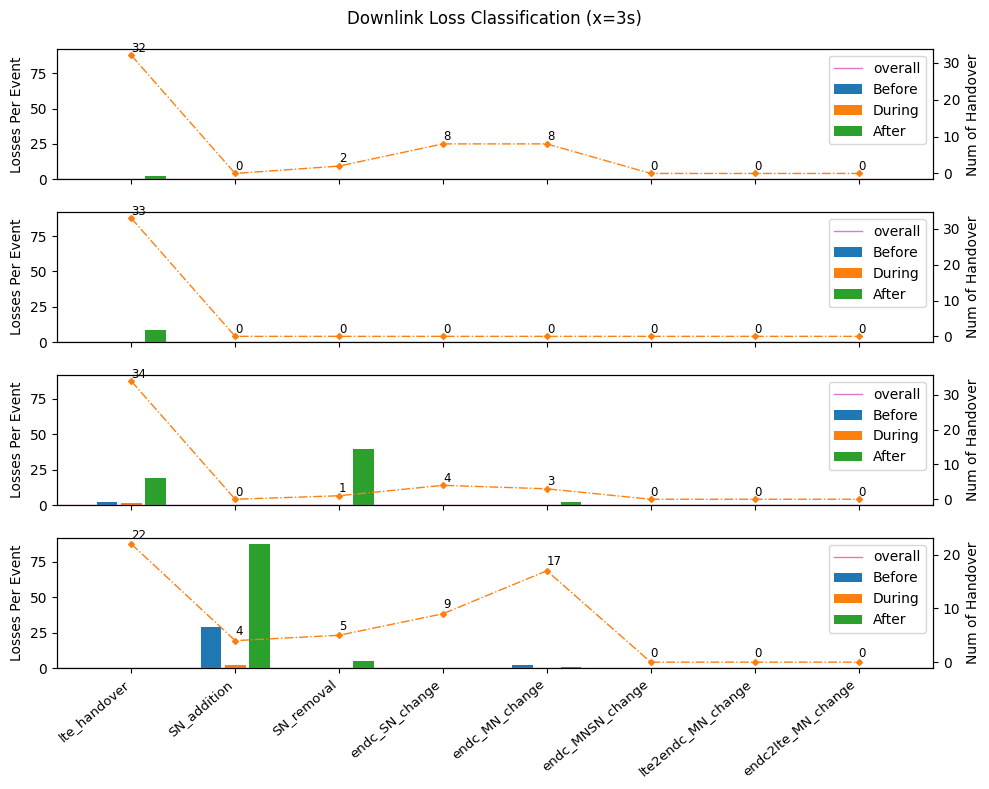

all@sm05
[85, 103704, 0.082]
[1962, 9310, 21.074]
[5, 253095, 0.002]
[2052, 366109, 0.56]
b3@sm06
[289, 81192, 0.356]
[864, 2566, 33.671]
[97, 232897, 0.042]
[1250, 316655, 0.395]
b28@sm07
[818, 81676, 1.002]
[553, 2387, 23.167]
[14, 220159, 0.006]
[1385, 304222, 0.455]
b3b28@sm08
[553, 106510, 0.519]
[391, 4487, 8.714]
[3, 218558, 0.001]
[947, 329555, 0.287]


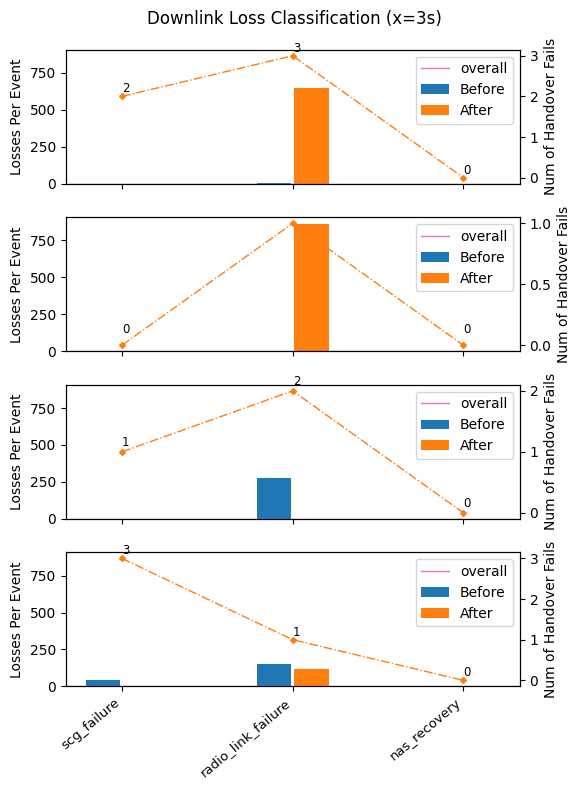

In [100]:
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    # "_Bandlock_Udp_B1_B3": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B1_B3": (1, ["#04"]),
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b1", "b3", "b28"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

### TODO Successful Handover: packet loss rate
# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)
fig.suptitle("Downlink Loss Classification (x=3s)")

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[[], [], []] for i in range(4)]
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type0.csv"))
            """"""
            datarows = df[df["secs"] == 3].to_numpy()
            # print(datarows)
            occurrences = [int(item) if item != '-' else 0 for item in datarows[0][2:]]
            durations = [float(item) for item in datarows[1][2:]]
            loss_num = [int(item) for item in datarows[2][2:]]
            total_num = [int(item) for item in datarows[3][2:]]
            loss_rate = [float(item) for item in datarows[4][2:]]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, type0 in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            # successful handover
            total_loss[0][0].append(sum(loss_num[-8:-5]))
            total_loss[0][1].append(sum(total_num[-8:-5]))
            # failed handover
            total_loss[1][0].append(sum(loss_num[-5:-3]))
            total_loss[1][1].append(sum(total_num[-5:-3]))
            # stable
            total_loss[2][0].append(loss_num[-2])
            total_loss[2][1].append(total_num[-2])
            # overall
            # total_loss[3][0].append(loss_num[-1])
            # total_loss[3][1].append(total_num[-1])
            total_loss[3][0].append(sum(loss_num[-8:-3]+[loss_num[-2]]))
            total_loss[3][1].append(sum(total_num[-8:-3]+[total_num[-2]]))
        
        for i in range(len(handover_types)):
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
            # before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            # during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            # after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            event_occurrences[i] = sum(event_occurrences[i])
        for i in range(4):
            total_loss[i][2] = round(sum(total_loss[i][0]) / (sum(total_loss[i][1]) + 1e-9) * 100, 3)
            total_loss[i][1] = sum(total_loss[i][1])
            total_loss[i][0] = sum(total_loss[i][0])

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        for i in range(4):
            print(total_loss[i])

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss[3][2], c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel("Num of Handover")
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "2(b1b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_sloss_rate.png"), bbox_inches='tight')
plt.show()

### TODO Failed Handover: pacekt loss rate
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, sharey=True)
fig.suptitle("Downlink Loss Classification (x=3s)")

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_fail_types))]
        before_event_loss = [[[], []] for i in range(len(handover_fail_types))]
        # during_event_loss = [[[], []] for i in range(len(handover_fail_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_fail_types))]
        total_loss  = [[[], [], []] for i in range(4)]
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type0.csv"))
            """"""
            datarows = df[df["secs"] == 3].to_numpy()
            # print(datarows)
            occurrences = [int(item) if item != '-' else 0 for item in datarows[0][2:]]
            durations = [float(item) for item in datarows[1][2:]]
            loss_num = [int(item) for item in datarows[2][2:]]
            total_num = [int(item) for item in datarows[3][2:]]
            loss_rate = [float(item) for item in datarows[4][2:]]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, type0 in enumerate(handover_fail_types):
                event_occurrences[i].append(occurrences[24 + 2*i])
                before_event_loss[i][0].append(loss_num[24 + 2*i])
                before_event_loss[i][1].append(total_num[24 + 2*i])
                # during_event_loss[i][0].append(loss_num[3*i + 1])
                # during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[24 + 2*i + 1])
                after_event_loss[i][1].append(total_num[24 + 2*i + 1])
            # successful handover
            total_loss[0][0].append(sum(loss_num[-8:-5]))
            total_loss[0][1].append(sum(total_num[-8:-5]))
            # failed handover
            total_loss[1][0].append(sum(loss_num[-5:-3]))
            total_loss[1][1].append(sum(total_num[-5:-3]))
            # stable
            total_loss[2][0].append(loss_num[-2])
            total_loss[2][1].append(total_num[-2])
            # overall
            # total_loss[3][0].append(loss_num[-1])
            # total_loss[3][1].append(total_num[-1])
            total_loss[3][0].append(sum(loss_num[-8:-3]+[loss_num[-2]]))
            total_loss[3][1].append(sum(total_num[-8:-3]+[total_num[-2]]))
        
        for i in range(len(handover_fail_types)):
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
            # before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            # after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            event_occurrences[i] = sum(event_occurrences[i])
        for i in range(4):
            total_loss[i][2] = round(sum(total_loss[i][0]) / (sum(total_loss[i][1]) + 1e-9) * 100, 3)
            total_loss[i][1] = sum(total_loss[i][1])
            total_loss[i][0] = sum(total_loss[i][0])

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        for i in range(4):
            print(total_loss[i])

        x = np.arange(len(handover_fail_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.22

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/2, before_event_loss, width, label='Before')
        # rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/2, after_event_loss, width, label='After')
        axs[k].axhline(total_loss[3][2], c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[k].set_ylabel('Packet Loss Rate (%)')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel("Num of Handover Fails")
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+0.1), size=8.5)

        axs[k].set_xticks(x, handover_fail_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "2(b1b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_floss_rate.png"), bbox_inches='tight')
plt.show()

### TODO Successful Handover: Loss per event
# fig, axs = plt.subplots(4,1, figsize=(12, 24), sharex=True, sharey=True)
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)
fig.suptitle("Downlink Loss Classification (x=3s)")

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_types))]
        before_event_loss = [[[], []] for i in range(len(handover_types))]
        during_event_loss = [[[], []] for i in range(len(handover_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_types))]
        total_loss  = [[[], [], []] for i in range(4)]
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type0.csv"))
            """"""
            datarows = df[df["secs"] == 3].to_numpy()
            # print(datarows)
            occurrences = [int(item) if item != '-' else 0 for item in datarows[0][2:]]
            durations = [float(item) for item in datarows[1][2:]]
            loss_num = [int(item) for item in datarows[2][2:]]
            total_num = [int(item) for item in datarows[3][2:]]
            loss_rate = [float(item) for item in datarows[4][2:]]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, type0 in enumerate(handover_types):
                event_occurrences[i].append(occurrences[3*i])
                before_event_loss[i][0].append(loss_num[3*i])
                before_event_loss[i][1].append(total_num[3*i])
                during_event_loss[i][0].append(loss_num[3*i + 1])
                during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[3*i + 2])
                after_event_loss[i][1].append(total_num[3*i + 2])
            # successful handover
            total_loss[0][0].append(sum(loss_num[-8:-5]))
            total_loss[0][1].append(sum(total_num[-8:-5]))
            # failed handover
            total_loss[1][0].append(sum(loss_num[-5:-3]))
            total_loss[1][1].append(sum(total_num[-5:-3]))
            # stable
            total_loss[2][0].append(loss_num[-2])
            total_loss[2][1].append(total_num[-2])
            # overall
            # total_loss[3][0].append(loss_num[-1])
            # total_loss[3][1].append(total_num[-1])
            total_loss[3][0].append(sum(loss_num[-8:-3]+[loss_num[-2]]))
            total_loss[3][1].append(sum(total_num[-8:-3]+[total_num[-2]]))
        
        for i in range(len(handover_types)):
            # before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            # during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(during_event_loss[i][1]) + 1e-9) * 100, 3)
            # after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            during_event_loss[i] = round(sum(during_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            event_occurrences[i] = sum(event_occurrences[i])
        for i in range(4):
            total_loss[i][2] = round(sum(total_loss[i][0]) / (sum(total_loss[i][1]) + 1e-9) * 100, 3)
            total_loss[i][1] = sum(total_loss[i][1])
            total_loss[i][0] = sum(total_loss[i][0])

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        for i in range(4):
            print(total_loss[i])

        x = np.arange(len(handover_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.7

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/3, before_event_loss, width, label='Before')
        rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/3, after_event_loss, width, label='After')
        axs[k].axhline(total_loss[3][2], c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        # axs[k].set_ylabel('Packet Loss Rate (%)')
        axs[k].set_ylabel('Losses Per Event')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel("Num of Handover")
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+1), size=8.5)

        axs[k].set_xticks(x, handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "2(b1b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_sloss_per_event.png"), bbox_inches='tight')
plt.show()

### TODO Failed Handover: Loss per event
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, sharey=True)
fig.suptitle("Downlink Loss Classification (x=3s)")

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        # print("----------------------")
        print('@'.join([stg, dev]))
        # print("----------------------")
        event_occurrences = [[] for i in range(len(handover_fail_types))]
        before_event_loss = [[[], []] for i in range(len(handover_fail_types))]
        # during_event_loss = [[[], []] for i in range(len(handover_fail_types))]
        after_event_loss  = [[[], []] for i in range(len(handover_fail_types))]
        total_loss  = [[[], [], []] for i in range(4)]
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify")
            df = pd.read_csv(os.path.join(source_dir, "dnlk_loss_classify_type0.csv"))
            """"""
            datarows = df[df["secs"] == 3].to_numpy()
            # print(datarows)
            occurrences = [int(item) if item != '-' else 0 for item in datarows[0][2:]]
            durations = [float(item) for item in datarows[1][2:]]
            loss_num = [int(item) for item in datarows[2][2:]]
            total_num = [int(item) for item in datarows[3][2:]]
            loss_rate = [float(item) for item in datarows[4][2:]]
            # print(occurrences)
            # print(durations)
            # print(loss_num)
            # print(total_num)
            # print(loss_rate)
            for i, type0 in enumerate(handover_fail_types):
                event_occurrences[i].append(occurrences[24 + 2*i])
                before_event_loss[i][0].append(loss_num[24 + 2*i])
                before_event_loss[i][1].append(total_num[24 + 2*i])
                # during_event_loss[i][0].append(loss_num[3*i + 1])
                # during_event_loss[i][1].append(total_num[3*i + 1])
                after_event_loss[i][0].append(loss_num[24 + 2*i + 1])
                after_event_loss[i][1].append(total_num[24 + 2*i + 1])
            # successful handover
            total_loss[0][0].append(sum(loss_num[-8:-5]))
            total_loss[0][1].append(sum(total_num[-8:-5]))
            # failed handover
            total_loss[1][0].append(sum(loss_num[-5:-3]))
            total_loss[1][1].append(sum(total_num[-5:-3]))
            # stable
            total_loss[2][0].append(loss_num[-2])
            total_loss[2][1].append(total_num[-2])
            # overall
            # total_loss[3][0].append(loss_num[-1])
            # total_loss[3][1].append(total_num[-1])
            total_loss[3][0].append(sum(loss_num[-8:-3]+[loss_num[-2]]))
            total_loss[3][1].append(sum(total_num[-8:-3]+[total_num[-2]]))
        
        for i in range(len(handover_fail_types)):
            # before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(before_event_loss[i][1]) + 1e-9) * 100, 3)
            # after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(after_event_loss[i][1]) + 1e-9) * 100, 3)
            before_event_loss[i] = round(sum(before_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            after_event_loss[i]  = round(sum(after_event_loss[i][0]) / (sum(event_occurrences[i]) + 1e-9), 3)
            event_occurrences[i] = sum(event_occurrences[i])
        for i in range(4):
            total_loss[i][2] = round(sum(total_loss[i][0]) / (sum(total_loss[i][1]) + 1e-9) * 100, 3)
            total_loss[i][1] = sum(total_loss[i][1])
            total_loss[i][0] = sum(total_loss[i][0])

        # print(event_occurrences)
        # print(before_event_loss)
        # print(during_event_loss)
        # print(after_event_loss)
        for i in range(4):
            print(total_loss[i])

        x = np.arange(len(handover_fail_types))  # the label locations
        width = 0.2  # the width of the bars
        space = 0.22

        # fig, ax = plt.subplots(nrows=1, ncols=1)
        rects1 = axs[k].bar(x - space/2, before_event_loss, width, label='Before')
        # rects2 = axs[k].bar(x          , during_event_loss, width, label='During')
        rects3 = axs[k].bar(x + space/2, after_event_loss, width, label='After')
        axs[k].axhline(total_loss[3][2], c = 'tab:pink', linewidth=1, label='overall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        # axs[k].set_ylabel('Packet Loss Rate (%)')
        axs[k].set_ylabel('Losses Per Event')
        # axs[k].set_title('Downlink Classification with successful handover (1 sec)')
        axs[k].legend()

        ax2 = axs[k].twinx()
        ax2.plot(x, event_occurrences, c='tab:orange', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel("Num of Handover Fails")
        for i, txt in enumerate(event_occurrences):
            ax2.annotate(str(event_occurrences[i]), (x[i], event_occurrences[i]+0.1), size=8.5)

        axs[k].set_xticks(x, handover_fail_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
        fig.tight_layout()

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "2(b1b3b28)")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "dnlk_floss_per_event.png"), bbox_inches='tight')
plt.show()

### Handover Interruption Time

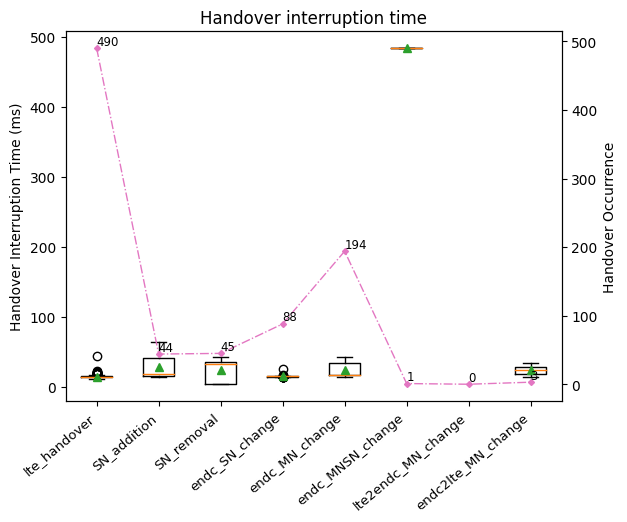

In [103]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/diag_log_ho-info.csv
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    "_Bandlock_Udp_B1_B3": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B1_B3": (1, ["#04"]),
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b1", "b3", "b28"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

ho_duration_list = [[] for i in range(len(handover_types))]
for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "data")
            df = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info_new.csv"))
            """"""
            df = df[df['handoff_state'] == 'start']
            for i, type0 in enumerate(handover_types):
                ho_duration_list[i] = [*ho_duration_list[i], *list(df[df['handoff_type'] == type0]['handoff_duration'].array * 1000)]

# total_ho_duration_list = [sum(lst) / 1000 for lst in ho_duration_list]
total_ho_occurrence_list = [len(lst) for lst in ho_duration_list]

# Plotting
# x = np.arange(len(dset))  # the label locations

fig, ax = plt.subplots()
ax.boxplot(ho_duration_list, showmeans=True)

ax.set_xticks(list(range(1, 9)), handover_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_title('Handover interruption time')
ax.set_ylabel('Handover Interruption Time (ms)')

ax2 = ax.twinx()
ax2.plot(list(range(1, 9)), total_ho_occurrence_list, c='tab:pink', linestyle='-.', linewidth=1, marker='D', markersize=3)
ax2.set_ylabel('Handover Occurrence')
for i, txt in enumerate(total_ho_occurrence_list):
    ax2.annotate(str(total_ho_occurrence_list[i]), (list(range(1, 9))[i], total_ho_occurrence_list[i]+5), size=8.5)

plt.show()

mkdir /home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07/images/3


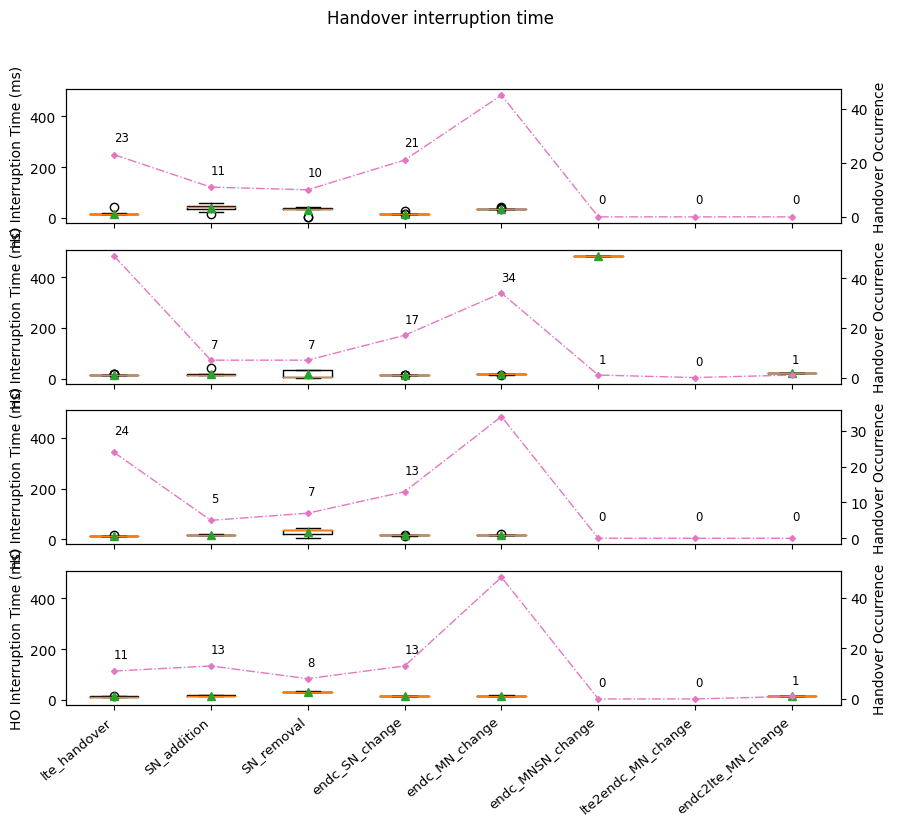

In [8]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/diag_log_ho-info.csv
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    "_Bandlock_Udp_B1_B3": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B1_B3": (1, ["#04"]),
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b1", "b3", "b28"]
setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)
fig.suptitle("Handover interruption time")

for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        ho_duration_list = [[] for i in range(len(handover_types))]
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "data")
            df = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info_new.csv"))
            """"""
            df = df[df['handoff_state'] == 'start']
            for i, type0 in enumerate(handover_types):
                ho_duration_list[i] = [*ho_duration_list[i], *list(df[df['handoff_type'] == type0]['handoff_duration'].array * 1000)]

        # total_ho_duration_list = [sum(lst) / 1000 for lst in ho_duration_list]
        total_ho_occurrence_list = [len(lst) for lst in ho_duration_list]

        # Plotting
        # x = np.arange(len(dset))  # the label locations

        # fig, ax = plt.subplots()
        axs[k].boxplot(ho_duration_list, showmeans=True)

        axs[k].set_xticks(list(range(1, 9)), handover_types)
        axs[k].set_xticklabels(axs[k].get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

        # ax.set_title('Handover interruption time')
        # ax.set_ylabel('Handover Interruption Time (ms)')
        axs[k].set_ylabel('HO Interruption Time (ms)')

        ax2 = axs[k].twinx()
        ax2.plot(list(range(1, 9)), total_ho_occurrence_list, c='tab:pink', linestyle='-.', linewidth=1, marker='D', markersize=3)
        ax2.set_ylabel('Handover Occurrence')
        for i, txt in enumerate(total_ho_occurrence_list):
            ax2.annotate(str(total_ho_occurrence_list[i]), (list(range(1, 9))[i], total_ho_occurrence_list[i]+5), size=8.5)

output_dir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-07", "images", "3")
makedir(output_dir)
plt.savefig(os.path.join(output_dir, "handover_interruption_time.png"), bbox_inches='tight')
plt.show()

### Inter-handover duration

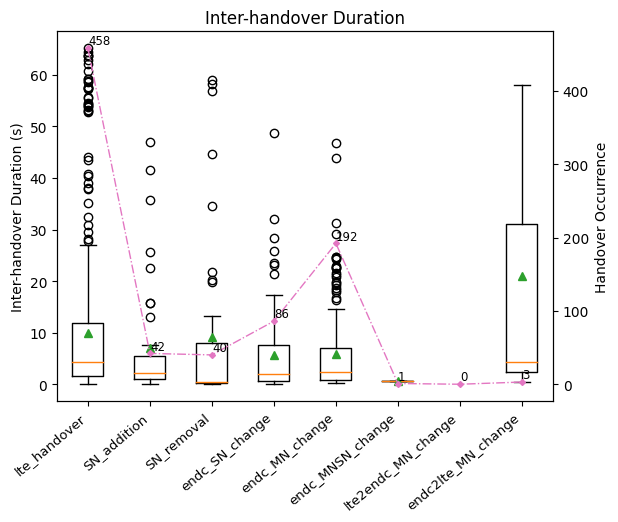

In [112]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/diag_log_ho-info.csv
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
    "_Bandlock_Udp_B1_B3": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B1_B3": (1, ["#04"]),
    # "_Bandlock_Udp_B3_B28": (1, ["#01"]),
    # "_Bandlock_Udp_B3_B28": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp_B28_B1": (1, ["#01"]),
    # "_Bandlock_Udp_B28_B1": (4, ["#01", "#02", "#03", "#04"]),
}
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b1", "b3", "b28"]
# setnames = ["all", "b3", "b28", "b3b28"]
# setnames = ["all", "b28", "b1", "b1b28"]
_setnames = ['@'.join([stg, dev]) for stg, dev in zip(setnames, devices)]
# print(_setnames)

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_types = handover_types_0
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

ho_duration_list = [[] for i in range(len(handover_types))]
for expr, (times, traces) in exps.items():
    for k, (dev, stg) in enumerate(zip(devices, setnames)):
        for trace in traces:
            """"""
            source_dir = os.path.join(database, date, expr, dev, trace, "data")
            df = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info_new.csv"))
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df['newcol'] = pd.Series(dtype=object)
            for i in range(len(df)):
                if df.at[i, 'handoff_state'] == 'end' and i != len(df)-1:
                    df.at[i, 'newcol'] = (df.at[i+1, 'Timestamp'] - df.at[i, 'Timestamp']).total_seconds()
            # print(df)
            """"""
            df = df[df['handoff_state'] == 'end']
            df = df.dropna()
            # print(df)
            for i, type0 in enumerate(handover_types):
                ho_duration_list[i] = [*ho_duration_list[i], *list(df[df['handoff_type'] == type0]['newcol'].array)]

# total_ho_duration_list = [sum(lst) / 1000 for lst in ho_duration_list]
total_ho_occurrence_list = [len(lst) for lst in ho_duration_list]

# Plotting
# x = np.arange(len(dset))  # the label locations

fig, ax = plt.subplots()
ax.boxplot(ho_duration_list, showmeans=True)

ax.set_xticks(list(range(1, 9)), handover_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_title('Inter-handover Duration')
ax.set_ylabel('Inter-handover Duration (s)')

ax2 = ax.twinx()
ax2.plot(list(range(1, 9)), total_ho_occurrence_list, c='tab:pink', linestyle='-.', linewidth=1, marker='D', markersize=3)
ax2.set_ylabel('Handover Occurrence')
for i, txt in enumerate(total_ho_occurrence_list):
    ax2.annotate(str(total_ho_occurrence_list[i]), (list(range(1, 9))[i], total_ho_occurrence_list[i]+5), size=8.5)

plt.show()